### HuggingFace transformers BERT

In [1]:
%cd ..
import torch
from transformers import BertForMaskedLM, BertConfig, Trainer, TrainingArguments
from inpainting.datasets import MNIST
from inpainting.callbacks import TrainingMonitor
from inpainting.utils import configure_environment

configure_environment()

/home/ventus/image-inpainting


2025-01-27 00:50:59.649728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-27 00:50:59.663902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-27 00:50:59.667928: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 00:50:59.679310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-27 00:51:00.727739: W tensorflow/compiler/tf2

Device set to cuda


In [2]:
mnist = MNIST(frac=0.01, clusters=299)

In [3]:
model = BertForMaskedLM(config=BertConfig(vocab_size=mnist.tokens+1, pad_token_id=mnist.tokens, max_position_embeddings=7*7, intermediate_size=6400)) #mnist.tokens))

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [4]:
BertConfig()

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.45.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [5]:
# Training arguments
training_args = TrainingArguments(
    output_dir="saved/bert_mlm_custom",
    num_train_epochs=50,
    per_device_train_batch_size=16,
    logging_dir="saved/bert_mlm_custom/logs",
    logging_steps=10,
    save_steps=1000,
	learning_rate=1e-6,
	logging_strategy="no",
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=mnist,
    callbacks=[TrainingMonitor]
)

In [6]:
trainer.train()

  0%|          | 0/1900 [00:00<?, ?it/s]

Epoch: 0.26	RMSE: 78.22	Loss: 3.53e+00	Learning Rate: 9.95e-07
Epoch: 0.53	RMSE: 78.31	Loss: 2.36e+00	Learning Rate: 9.89e-07
Epoch: 0.79	RMSE: 78.31	Loss: 2.31e+00	Learning Rate: 9.84e-07
Epoch: 1.05	RMSE: 81.07	Loss: 2.32e+00	Learning Rate: 9.79e-07
Epoch: 1.32	RMSE: 81.07	Loss: 2.19e+00	Learning Rate: 9.74e-07
Epoch: 1.58	RMSE: 82.40	Loss: 2.10e+00	Learning Rate: 9.68e-07
Epoch: 1.84	RMSE: 81.83	Loss: 2.06e+00	Learning Rate: 9.63e-07
Epoch: 2.11	RMSE: 84.42	Loss: 1.98e+00	Learning Rate: 9.58e-07
Epoch: 2.37	RMSE: 83.79	Loss: 1.93e+00	Learning Rate: 9.53e-07
Epoch: 2.63	RMSE: 82.90	Loss: 1.87e+00	Learning Rate: 9.47e-07
Epoch: 2.89	RMSE: 81.07	Loss: 1.84e+00	Learning Rate: 9.42e-07
Epoch: 3.16	RMSE: 81.92	Loss: 1.88e+00	Learning Rate: 9.37e-07
Epoch: 3.42	RMSE: 81.29	Loss: 1.82e+00	Learning Rate: 9.32e-07
Epoch: 3.68	RMSE: 79.51	Loss: 1.79e+00	Learning Rate: 9.26e-07
Epoch: 3.95	RMSE: 77.58	Loss: 1.76e+00	Learning Rate: 9.21e-07
Epoch: 4.21	RMSE: 77.06	Loss: 1.63e+00	Learning Rate: 9

TrainOutput(global_step=1900, training_loss=0.9384326171875, metrics={'train_runtime': 360.0713, 'train_samples_per_second': 83.317, 'train_steps_per_second': 5.277, 'total_flos': 1296805138020000.0, 'train_loss': 0.9384326171875, 'epoch': 50.0})

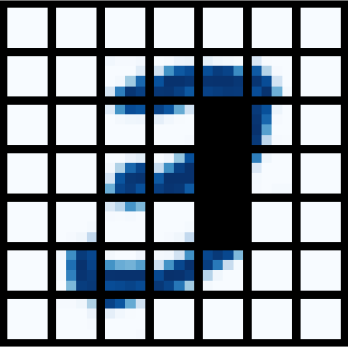

In [7]:
x = mnist[7]["input_ids"]
mnist.plot_sample(x)

In [8]:
model.eval()  # Set the model in evaluation mode (turn off dropout, batch norm in eval mode)
with torch.no_grad():  # Disable gradient calculation
    outputs = model(x.unsqueeze(0).cuda()).logits.detach().cpu()

In [9]:
y = torch.softmax(outputs, dim=-1).argmax(dim=-1)

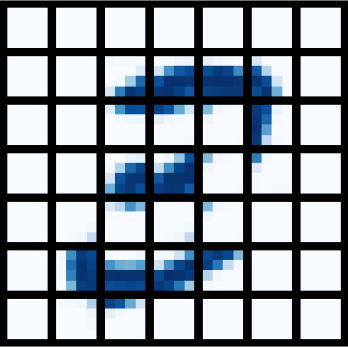

In [10]:
mnist.plot_sample(y)